In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from models.regression import BayesianRegressor
from utils.experiments import experiment
from utils.vis import visualize_training, weights_histogram, visualize_inference
from utils.predictive import mean_var_predictive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creating Training Data

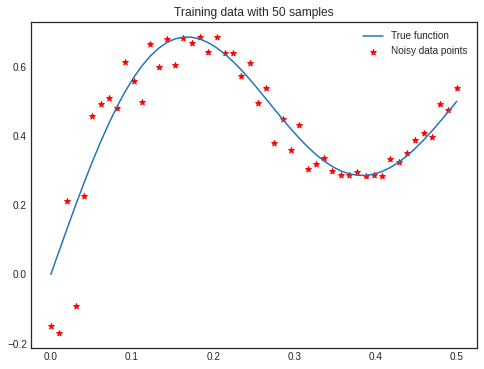

In [3]:
# toy dataset we can start with
train_samples = 50
x_train, y_train = experiment(xmin = 0.0, xmax = 0.5, samples = train_samples, std = 0.02)
_, y_train_true = experiment(xmin = 0.0, xmax = 0.5, samples = train_samples, std = 0)
# Visualizing data sample
_ = visualize_training(x_train.numpy(), y_train.numpy(), y_train_true.numpy())

## homoscedastic uncertainty
Defining model and training

In [4]:
ll_var = 0.05**2 # In the paper they always work with the stdv!
model = BayesianRegressor(hidden_dim=128, ll_var=ll_var, mixture_prior=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
elbo_samples = 6
epochs = 2000

x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = model.energy_loss(x_train, y_train, elbo_samples)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 6622.798828125
epoch: 101/2000
Loss: 2852.673095703125
epoch: 201/2000
Loss: 2442.59326171875
epoch: 301/2000
Loss: 2167.9150390625
epoch: 401/2000
Loss: 1993.8280029296875
epoch: 501/2000
Loss: 1817.548095703125
epoch: 601/2000
Loss: 1758.2086181640625
epoch: 701/2000
Loss: 1638.1571044921875
epoch: 801/2000
Loss: 1589.5186767578125
epoch: 901/2000
Loss: 1594.16357421875
epoch: 1001/2000
Loss: 1511.18359375
epoch: 1101/2000
Loss: 1517.4189453125
epoch: 1201/2000
Loss: 1509.5548095703125
epoch: 1301/2000
Loss: 1441.6436767578125
epoch: 1401/2000
Loss: 1448.649169921875
epoch: 1501/2000
Loss: 1390.1724853515625
epoch: 1601/2000
Loss: 1424.7333984375
epoch: 1701/2000
Loss: 1355.484619140625
epoch: 1801/2000
Loss: 1393.782470703125
epoch: 1901/2000
Loss: 1364.5863037109375
Finished Training


Prediction

In [5]:
# samples is the number of "predictions" we make for 1 x-value.
test_samples = 500
exp_samples = 100
x_test, y_test = experiment(xmin = -0.2, xmax = 0.8, samples = test_samples, std = 0.02)
_, y_test_true = experiment(xmin = -0.2, xmax = 0.8, samples = test_samples, std = 0)
y_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
x_test = x_test.to(device)
for s in range(exp_samples):
    y_hat = model.forward(x_test).cpu().detach().numpy()
    y_samp[s, :] = y_hat.reshape(-1)

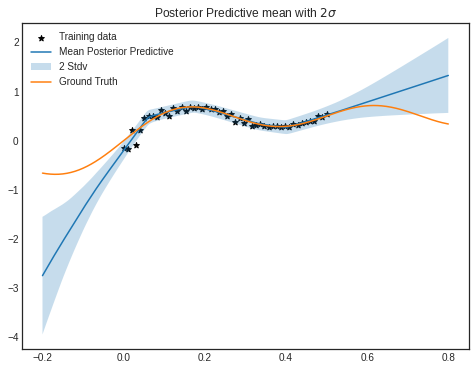

In [6]:
# Computing mean and variance of predictive distribution
predictive_mean, predictive_var = mean_var_predictive(y_samp, np.array(ll_var))
_ = visualize_inference(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy(),
                        x_test.cpu().detach().numpy(), y_test_true.cpu().detach().numpy(),
                        predictive_mean, predictive_var)


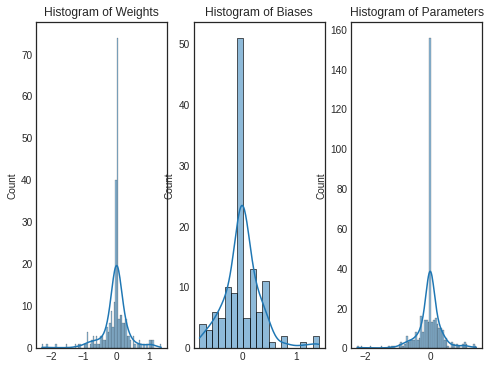

In [7]:
_, _ = weights_histogram(model)


